In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'} 

In [18]:
models = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/Results/models.csv', index_col=0)
gcn = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/Results/GCN.csv', index_col=0).rename(columns={'acc_test' : 'test_acc'})
gcn['Model'] = 'GCN'
gat = pd.read_csv('/Users/rodrigo/Post-Grad/CC400/Results/GAT.csv', index_col=0).rename(columns={'acc_test' : 'test_acc'})
gat['Model'] = 'GAT'


In [19]:
models = models.merge(gcn, how='outer')
models = models.merge(gat, how='outer')

In [22]:
models.columns

Index(['fit_time', 'score_time', 'test_acc', 'test_prec_macro',
       'test_rec_macro', 'test_f1', 'test_roc_auc', 'Model'],
      dtype='object')

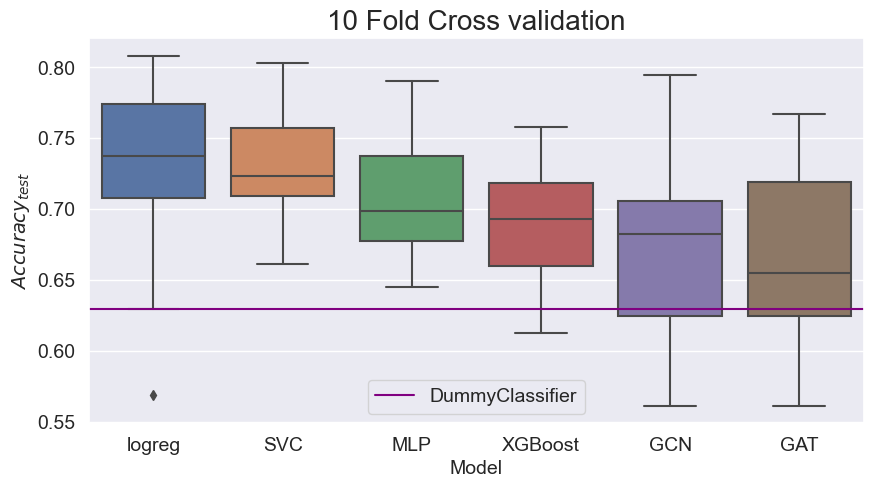

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(models, x='Model', y='test_acc')
plt.axhline(y = 0.63, color = 'purple', linestyle = '-', label='DummyClassifier')
plt.legend()
plt.ylabel(r'$Accuracy_{test}$')
plt.title('10 Fold Cross validation')
plt.show()

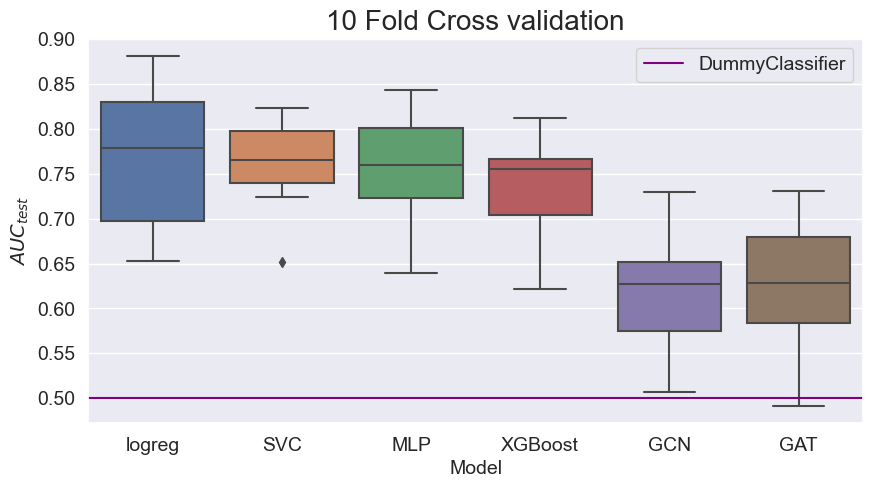

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(models, x='Model', y='test_roc_auc')
plt.axhline(y = 0.5, color = 'purple', linestyle = '-', label='DummyClassifier')
plt.legend()
plt.ylabel(r'$AUC_{test}$')
plt.title('10 Fold Cross validation')
plt.show()

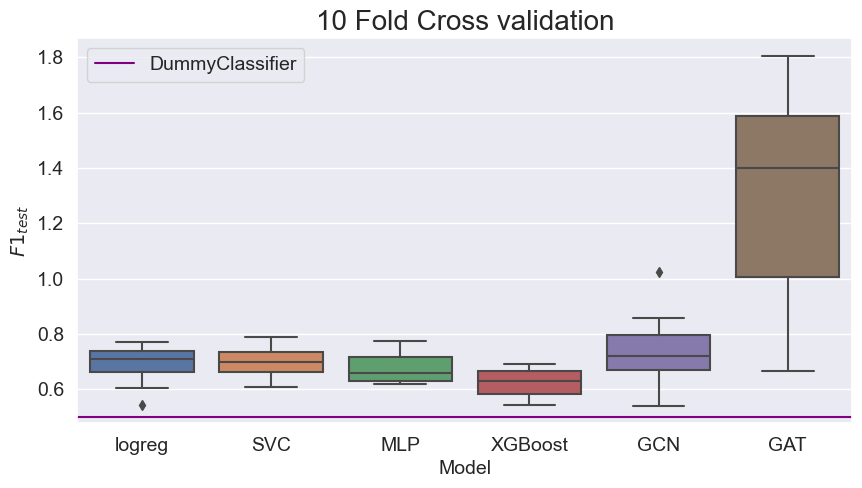

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(models, x='Model', y='test_f1')
plt.axhline(y = 0.5, color = 'purple', linestyle = '-', label='DummyClassifier')
plt.legend()
plt.ylabel(r'$F1_{test}$')
plt.title('10 Fold Cross validation')
plt.show()

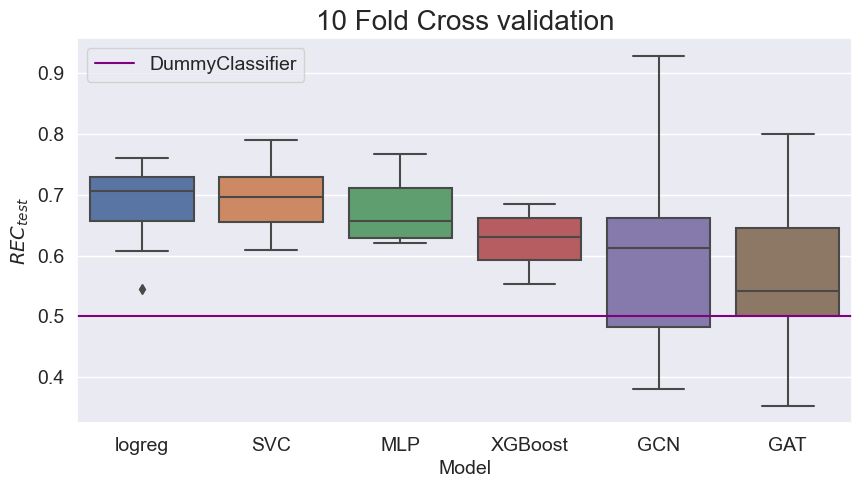

In [30]:
plt.figure(figsize=(10,5))
sns.boxplot(models, x='Model', y='test_rec_macro')
plt.axhline(y = 0.5, color = 'purple', linestyle = '-', label='DummyClassifier')
plt.legend()
plt.ylabel(r'$REC_{test}$')
plt.title('10 Fold Cross validation')
plt.show()

In [33]:
gat

,test_acc,test_prec_macro,test_rec_macro,test_f1,test_roc_auc,Model
0,0.753425,0.741379,0.800000,1.157532,0.689614,GAT
1,0.767123,0.784314,0.727273,0.664959,0.731079,GAT
2,0.698630,0.714286,0.647059,0.906282,0.638486,GAT
3,0.726027,0.770833,0.640000,0.954441,0.698470,GAT
4,0.561644,0.625000,0.352941,1.805164,0.491546,GAT
5,0.630137,0.693878,0.500000,1.599276,0.591787,GAT
6,0.597222,0.660377,0.421053,1.730968,0.534281,GAT
7,0.625000,0.725000,0.500000,1.546013,0.618519,GAT
8,0.625000,0.680000,0.500000,1.365676,0.581481,GAT
9,0.680556,0.729167,0.583333,1.432050,0.648148,GAT


In [32]:
models

,fit_time,score_time,test_acc,test_prec_macro,test_rec_macro,test_f1,test_roc_auc,Model
0,8.311548,0.257778,0.794521,0.788324,0.760467,0.769619,0.838969,logreg
1,8.279165,0.231043,0.780822,0.783626,0.734300,0.746087,0.803543,logreg
2,8.185263,0.221627,0.808219,0.834034,0.756039,0.772282,0.881643,logreg
3,8.375173,0.263058,0.753425,0.741758,0.712560,0.720663,0.858293,logreg
4,8.352999,0.292992,0.739726,0.721088,0.709340,0.713725,0.805153,logreg
5,8.204637,0.247522,0.630137,0.605556,0.607085,0.606194,0.687601,logreg
6,8.197181,0.268318,0.736111,0.713842,0.701505,0.706122,0.688127,logreg
7,8.263145,0.238438,0.569444,0.543831,0.544444,0.544025,0.652675,logreg
8,2.014924,0.108476,0.708333,0.690385,0.662963,0.668348,0.753086,logreg
9,1.828908,0.118204,0.708333,0.694444,0.655556,0.660606,0.727572,logreg


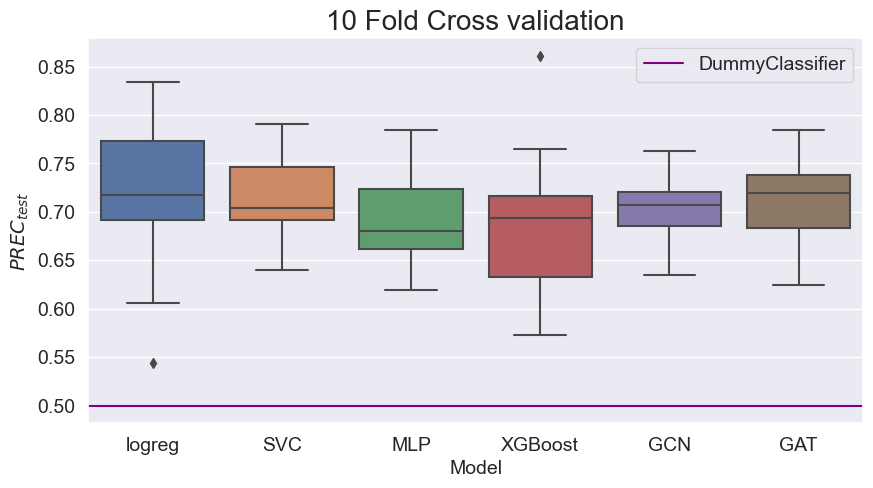

In [31]:
plt.figure(figsize=(10,5))
sns.boxplot(models, x='Model', y='test_prec_macro')
plt.axhline(y = 0.5, color = 'purple', linestyle = '-', label='DummyClassifier')
plt.legend()
plt.ylabel(r'$PREC_{test}$')
plt.title('10 Fold Cross validation')
plt.show()


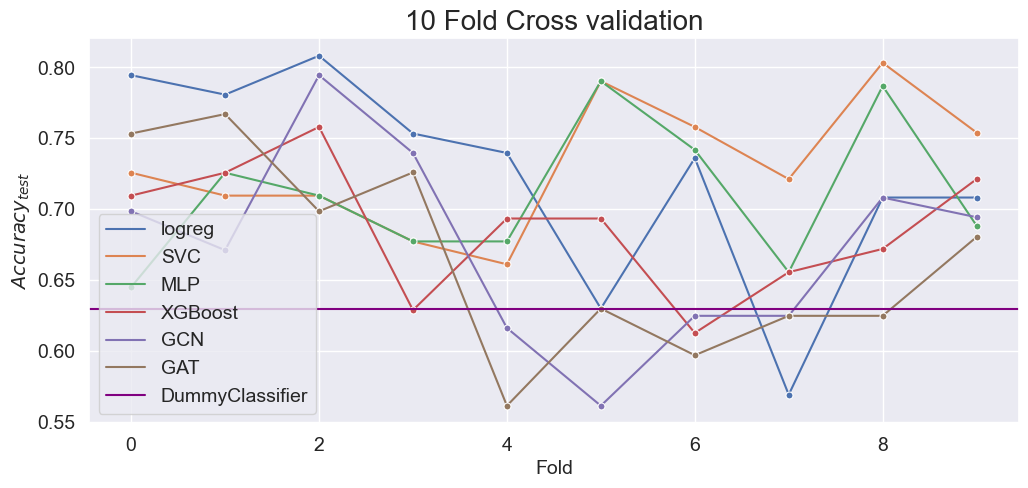

In [26]:
plt.figure(figsize=(12,5))
sns.lineplot(models, x=6*[i for i in range(0,10)], hue='Model', y='test_acc', marker='.', markersize=10)
plt.axhline(y = 0.63, color = 'purple', linestyle = '-', label='DummyClassifier')
plt.legend()
plt.xlabel('Fold')
plt.ylabel(r'$Accuracy_{test}$')
plt.title('10 Fold Cross validation')
plt.show()